# Supervised Topic Modeling with Latent Dirichlet Allocation

While LDA can be used to explore the latent topic space in a corpus, it can also support a supervised classifier for a given set of topics. This notebook trains an LDA model on the BBC corpus of 2225 news articles classified into 5 topics: Politics, Business, Sport, Tech, and Entertainment. We will see that it predicts the test set quite accurately. We will also see how to explore the word-topic space generated by LDA, and how to explore misclassifications. 

## Imports & Settings

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
%matplotlib inline

from collections import OrderedDict, defaultdict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

In [4]:
sns.set_style('white')
plt.rcParams['figure.figsize'] = (14.0, 8.7)

In [6]:
pyLDAvis.enable_notebook()

## Load BBC data

To use this notebook, you must download the [BBC corpus](http://mlg.ucd.ie/files/datasets/bbc.zip) and extract it to a folder visible from this notebook.

In [7]:
# change to your data path if necessary
DATA_DIR = Path('./data')
data_path = DATA_DIR / 'bbc'

In [8]:
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

In [9]:
files = sorted(list(data_path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

### Convert to DataFrame

In [10]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


## Create Train & Test Sets

In [15]:
train_docs, test_docs = train_test_split(docs,
                                         stratify=docs.topic,
                                         test_size=125,
                                         random_state=42)

In [16]:
X = train_docs.article
Y = train_docs.topic

In [17]:
X.shape, Y.shape

((2100,), (2100,))

## LDA with sklearn

We will use `sklearn.model_selection.GridSearchCV` to find the optimal hyperparameters for the LDA model over the BBC dataset.

In [23]:
vectorizer = TfidfVectorizer(stop_words='english')
model = LatentDirichletAllocation()
pipeline = Pipeline(steps=[('vec', vectorizer), ('model', model)])
grid_params = {
    'vec__ngram_range': [(1,1), (1,2), (1,3)],
    'vec__max_df': [0.17, 0.2, 0.23],
    'vec__min_df': [i/1000 for i in range(6, 20, 2)], 
    'vec__stop_words': ['english'],
    'model__n_components': [5],
    'model__max_iter': [500],
    'model__evaluate_every': [5],
}
best_estimator = GridSearchCV(estimator=pipeline, param_grid=grid_params, n_jobs=5)
best_estimator.fit(X=X, y=Y)



GridSearchCV(estimator=Pipeline(steps=[('vec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model', LatentDirichletAllocation())]),
             n_jobs=5,
             param_grid={'model__evaluate_every': [5], 'model__max_iter': [500],
                         'model__n_components': [5],
                         'vec__max_df': [0.17, 0.2, 0.23],
                         'vec__min_df': [0.006, 0.008, 0.01, 0.012, 0.014,
                                         0.016, 0.018],
                         'vec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vec__stop_words': ['english']})

In [26]:
result_dict = defaultdict(list)
for result in best_estimator.cv_results_['params']:
    for k, v in result.items():
        if k in ('vec__ngram_range', 'vec__max_df', 'vec__min_df'):
            result_dict[k].append(v)
df_results = pd.DataFrame(result_dict)
df_results['score'] = best_estimator.cv_results_['mean_test_score']
print(df_results.sort_values(by=['score'], ascending=False))

    vec__max_df  vec__min_df vec__ngram_range         score
18         0.17        0.018           (1, 1) -27198.606380
60         0.23        0.018           (1, 1) -27547.967113
39         0.20        0.018           (1, 1) -27792.962273
41         0.20        0.018           (1, 3) -27839.421409
19         0.17        0.018           (1, 2) -27897.213395
..          ...          ...              ...           ...
2          0.17        0.006           (1, 3) -37358.532509
43         0.23        0.006           (1, 2) -37482.568962
22         0.20        0.006           (1, 2) -37575.603604
23         0.20        0.006           (1, 3) -37784.620223
44         0.23        0.006           (1, 3) -38146.343666

[63 rows x 4 columns]


N-grams do not seem to facilitate the search for a latent topic space in this dataset, so we will drop `ngram_range` from the search and focus on the minimum and maximum document frequencies in the Term Frequency - Inverse Document Frequency vectorizer (`sklearn.feature_extraction.text.TfidfVectorizer`).

I have reproduced my entire search below. On each iteration I checked the test set prediction accuracy of the optimal pipeline selected by the grid search. When test accuracy began diverging from training loss, I halted the search and retrained on the best hyperparameters as measured by test set accuracy. 

In [30]:
grid_params = {
    'vec__max_df': [i/100 for i in range(14, 19)],
    'vec__min_df': [i/1000 for i in range(17, 23)], 
    'vec__stop_words': ['english'],
    'model__n_components': [5],
    'model__max_iter': [500],
    'model__evaluate_every': [5],
}
best_estimator = GridSearchCV(estimator=pipeline, param_grid=grid_params, n_jobs=5)
best_estimator.fit(X=X, y=Y)
result_dict = defaultdict(list)
for result in best_estimator.cv_results_['params']:
    for k, v in result.items():
        if k in ('vec__ngram_range', 'vec__max_df', 'vec__min_df'):
            result_dict[k].append(v)
df_results = pd.DataFrame(result_dict)
df_results['score'] = best_estimator.cv_results_['mean_test_score']
print(df_results.sort_values(by=['score'], ascending=False))

    vec__max_df  vec__min_df         score
5          0.14        0.022 -24660.690887
4          0.14        0.021 -25124.025598
11         0.15        0.022 -25193.188968
29         0.18        0.022 -25294.230709
10         0.15        0.021 -25384.841206
17         0.16        0.022 -25487.156150
23         0.17        0.022 -25507.530909
16         0.16        0.021 -25538.121351
3          0.14        0.020 -25659.995170
22         0.17        0.021 -25705.033373
2          0.14        0.019 -25955.825240
28         0.18        0.021 -26169.295332
15         0.16        0.020 -26239.672797
14         0.16        0.019 -26300.114420
9          0.15        0.020 -26307.061211
21         0.17        0.020 -26310.310304
7          0.15        0.018 -26451.337286
27         0.18        0.020 -26453.199554
8          0.15        0.019 -26508.011162
1          0.14        0.018 -26510.386670
26         0.18        0.019 -26676.083061
13         0.16        0.018 -26751.296531
20         

In [72]:
grid_params = {
    'vec__max_df': [i/100 for i in range(11, 16)],
    'vec__min_df': [i/1000 for i in range(22, 27)], 
    'vec__stop_words': ['english'],
    'model__n_components': [5],
    'model__max_iter': [500],
    'model__evaluate_every': [5],
}
best_estimator = GridSearchCV(estimator=pipeline, param_grid=grid_params, n_jobs=5)
best_estimator.fit(X=X, y=Y)
result_dict = defaultdict(list)
for result in best_estimator.cv_results_['params']:
    for k, v in result.items():
        if k in ('vec__ngram_range', 'vec__max_df', 'vec__min_df'):
            result_dict[k].append(v)
df_results = pd.DataFrame(result_dict)
df_results['score'] = best_estimator.cv_results_['mean_test_score']
print(df_results.sort_values(by=['score'], ascending=False))

    vec__max_df  vec__min_df         score
4          0.11        0.026 -22087.331879
9          0.12        0.026 -22246.802526
3          0.11        0.025 -22379.681270
2          0.11        0.024 -22687.881543
14         0.13        0.026 -22879.947256
8          0.12        0.025 -22922.453032
1          0.11        0.023 -23012.026053
19         0.14        0.026 -23121.174688
7          0.12        0.024 -23135.200164
24         0.15        0.026 -23341.041463
12         0.13        0.024 -23355.557784
13         0.13        0.025 -23427.242249
6          0.12        0.023 -23603.154730
0          0.11        0.022 -23737.281422
18         0.14        0.025 -23754.307553
11         0.13        0.023 -23847.026519
17         0.14        0.024 -23909.866370
23         0.15        0.025 -23955.945037
22         0.15        0.024 -24060.701470
5          0.12        0.022 -24079.006975
16         0.14        0.023 -24247.439063
10         0.13        0.022 -24499.980096
21         

In [43]:
grid_params = {
    'vec__max_df': [i/100 for i in range(11, 16)],
    'vec__min_df': [i/1000 for i in range(22, 27)], 
    'vec__stop_words': ['english'],
    'model__n_components': [5],
    'model__max_iter': [500],
    'model__evaluate_every': [5],
}
_estimator = GridSearchCV(estimator=pipeline, param_grid=grid_params, n_jobs=5)
best_estimator.fit(X=X, y=Y)
result_dict = defaultdict(list)
for result in best_estimator.cv_results_['params']:
    for k, v in result.items():
        if k in ('vec__ngram_range', 'vec__max_df', 'vec__min_df'):
            result_dict[k].append(v)
df_results = pd.DataFrame(result_dict)
df_results['score'] = best_estimator.cv_results_['mean_test_score']
print(df_results.sort_values(by=['score'], ascending=False))

    vec__max_df  vec__min_df         score
4          0.07        0.030 -16312.962680
3          0.07        0.029 -16691.040184
2          0.07        0.028 -17064.098108
1          0.07        0.027 -17599.039755
9          0.08        0.030 -17653.922685
8          0.08        0.029 -18104.552141
0          0.07        0.026 -18148.307718
7          0.08        0.028 -18544.972425
14         0.09        0.030 -18905.786954
6          0.08        0.027 -19028.428615
13         0.09        0.029 -19366.783901
5          0.08        0.026 -19432.405601
19         0.10        0.030 -19531.072137
12         0.09        0.028 -19594.348104
18         0.10        0.029 -19826.475822
11         0.09        0.027 -20009.696312
24         0.11        0.030 -20019.541027
17         0.10        0.028 -20387.561223
10         0.09        0.026 -20565.860769
16         0.10        0.027 -20673.243133
23         0.11        0.029 -20741.962345
22         0.11        0.028 -20925.972748
15         

## Explore topics & word distributions

In [27]:
n_components = 5
topic_labels = [f'Topic {i}' for i in range(1, n_components+1)]

In [73]:
pipeline_vectorizer = best_estimator.best_estimator_.steps[0][1]
words = pipeline_vectorizer.get_feature_names()
lda = best_estimator.best_estimator_.steps[1][1]

In [74]:
# pseudo counts
topics_count = lda.components_
print(topics_count.shape)
topics_count[:5]

(5, 1097)


array([[1.35837233, 4.53287727, 4.04684264, ..., 0.54757668, 6.25124504,
        5.21277207],
       [4.09039126, 5.89905535, 6.42269646, ..., 0.4160388 , 5.3036271 ,
        0.24321321],
       [1.39276356, 2.64315126, 3.76872676, ..., 2.30288858, 1.7368829 ,
        4.64621307],
       [3.62285449, 1.18845865, 3.08490168, ..., 0.47778794, 2.40331614,
        1.21516048],
       [4.07328547, 2.81156113, 2.17960519, ..., 6.61170335, 0.20849192,
        4.88273596]])

In [75]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
100,0.000767,0.001376,0.000471,0.001471,0.001168
11,0.002561,0.001984,0.000893,0.000483,0.000806
12,0.002286,0.002160,0.001273,0.001253,0.000625
13,0.001958,0.001137,0.001322,0.000501,0.000272
14,0.001193,0.001098,0.001048,0.000680,0.000740


In [76]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

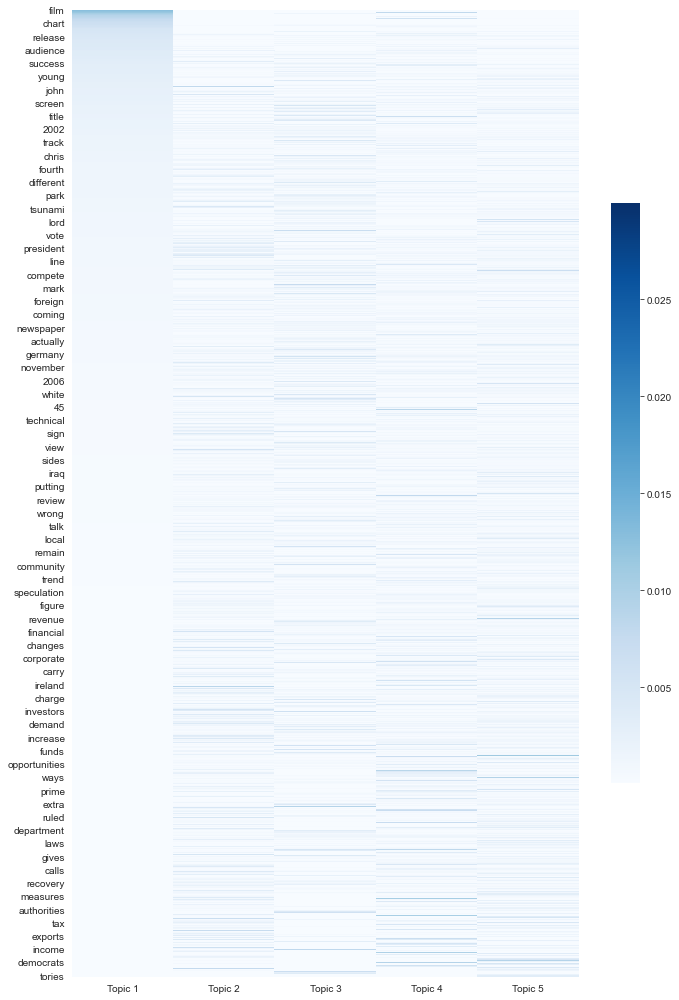

In [77]:
fig, ax = plt.subplots(figsize=(10, 14))
sns.heatmap(topics.sort_values(topic_labels, ascending=False),
            cmap='Blues', ax=ax, cbar_kws={'shrink': .6})
fig.tight_layout()

Before I optimized the LDA model, I used minimum and maximum document frequencies suggested by a notebook [here](https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/15_topic_modeling/04_lda_with_sklearn.ipynb). The model built on the resulting document-term matrix had very poor predictive power; two topics were never predicted, for example. The two topics that were never predicted had identical word-vectors and no internal coherence.

The word-topic table below, by contrast, has highly relevant and easily distinguished sets of most relevant words for each topic.

In [78]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,film,bank,club,technology,labour
1,awards,growth,team,mobile,blair
2,award,sales,match,software,party
3,music,economy,cup,users,election
4,band,shares,season,digital,brown
5,star,oil,injury,computer,law
6,album,china,final,games,howard
7,actor,economic,ireland,music,prime
8,films,prices,chelsea,online,court
9,singer,deal,coach,phone,police


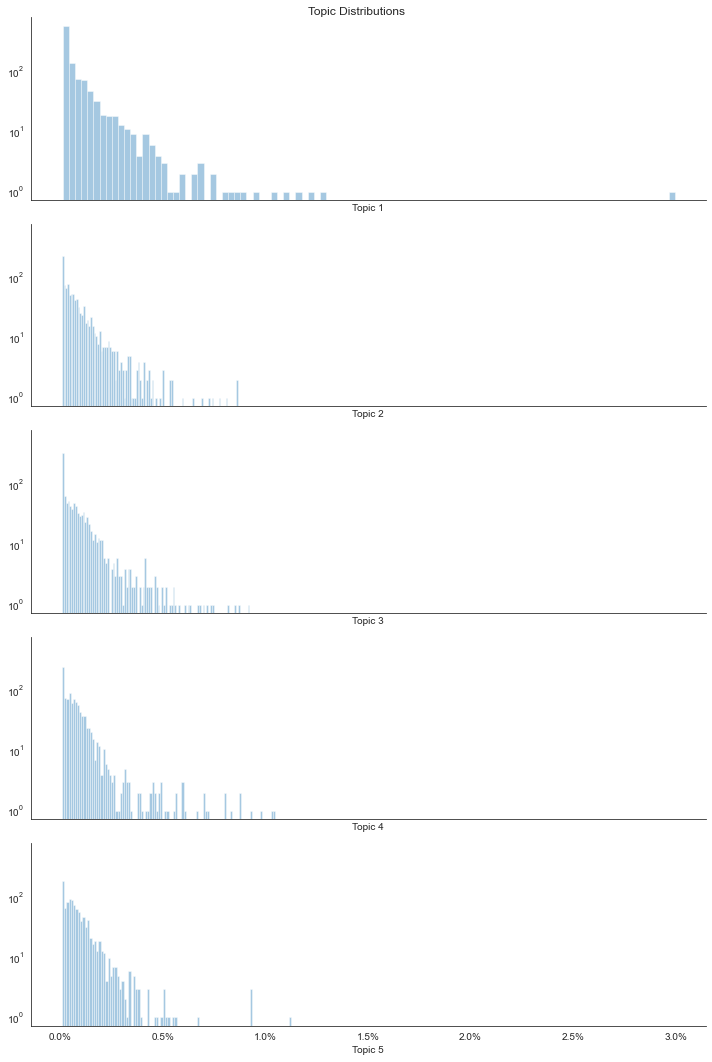

In [79]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(10, 15))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
sns.despine()
fig.tight_layout()

## Evaluate Fit on Test Set 

In [80]:

test_preds = best_estimator.transform(test_docs.article)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)

In [82]:
test_eval.shape

(125, 5)

### Plotting the Class-Topic Association

While LDA can find latent topics, it cannot assign them labels more meaningful than "Topic 1," "Topic 2," etc. The association between a document class and its related LDA topic fairly leaps from the histogram below. 

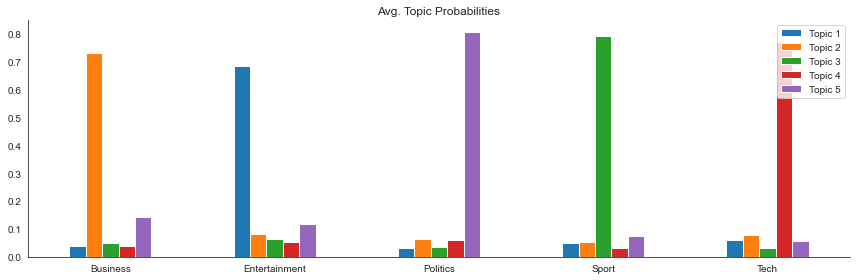

In [83]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities',
                                                 figsize=(12, 4),
                                                 rot=0)
plt.xlabel('')
sns.despine()
plt.tight_layout()

### Visualizing Topic Predictions

The confusion matrix below shows that the LDA topic predictions are highly accurate and have no particular bias toward any one topic.

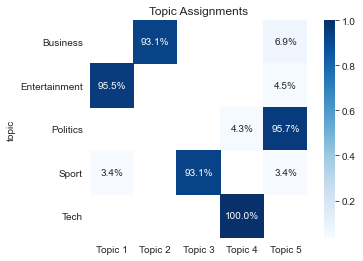

In [84]:
df = test_eval.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True).unstack(-1), 
            annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

## Explore misclassified articles 

In [115]:
test_assignments = pd.DataFrame(test_eval.idxmax(axis=1), columns=["prediction"])
test_assignments['heading'] = test_docs.heading.values
test_assignments['article'] = test_docs.article.values
test_assignments.head()

,prediction,heading,article
topic,,,
Politics,Topic 5,Kilroy launches 'Veritas' party,Ex-BBC chat show host and East Midlands MEP R...
Sport,Topic 3,Radcliffe eyes hard line on drugs,Paula Radcliffe has called for all athletes f...
Business,Topic 2,S Korean consumers spending again,South Korea looks set to sustain its revival ...
Business,Topic 2,Quiksilver moves for Rossignol,"Shares of Skis Rossignol, the world's largest..."
Tech,Topic 4,Britons fed up with net service,A survey conducted by PC Pro Magazine has rev...


In [119]:
misclassified = test_assignments[(test_assignments.index == 'Business') & (
    test_assignments.prediction != 'Topic 2')]
misclassified = misclassified.append(test_assignments[(test_assignments.index == 'Entertainment') & (
    test_assignments.prediction != 'Topic 1')])
misclassified = misclassified.append(test_assignments[(test_assignments.index == 'Politics') & (
    test_assignments.prediction != 'Topic 5')])
misclassified = misclassified.append(test_assignments[(test_assignments.index == 'Sport') & (
    test_assignments.prediction != 'Topic 3')])
misclassified = misclassified.append(test_assignments[(test_assignments.index == 'Tech') & (
    test_assignments.prediction != 'Topic 4')])
misclassified.head(10)

,prediction,heading,article
topic,,,
Business,Topic 5,Ebbers denies WorldCom fraud,Former WorldCom chief Bernie Ebbers has denie...
Business,Topic 5,Disney settles disclosure charges,Walt Disney has settled charges from US feder...
Entertainment,Topic 5,Campaigners attack MTV 'sleaze',"MTV has been criticised for ""incessant sleaze..."
Politics,Topic 4,UK firms 'embracing e-commerce',UK firms are embracing internet trading oppor...
Sport,Topic 5,Calder fears for Scottish rugby,Former Scotland international Finlay Calder f...
Sport,Topic 1,Holmes feted with further honour,Double Olympic champion Kelly Holmes has been...


In [120]:
misclassified.article.tolist()

[' Former WorldCom chief Bernie Ebbers has denied claims that he knew accountants were doctoring the books at the firm.  Speaking in court, Mr Ebbers rejected allegations he pressured ex-chief financial officer Scott Sullivan to falsify company financial statements. Mr Sullivan "made accounting decisions," he told the federal court, saying his finance chief had "a keen command of the numbers". Mr Ebbers has denied charges of fraud and conspiracy. During his second day of questioning in the New York trial Mr Ebbers played down his working relationship with Mr Sullivan and denied he frequently met him to discuss company business when questioned by the prosecution.  "In a lot of weeks, we would speak ... three or four times," Mr Ebbers said, adding that conversations about finances were rarely one-on-one and were usually discussed by a "group of people" instead.  Mr Ebbers relationship to Mr Sullivan is key to the case surrounding financial corruption that led to the collapse of the firm 

## PyLDAVis

According to [Stefan Jansen](https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/15_topic_modeling/04_lda_with_sklearn.ipynb),

>LDAvis helps you interpret LDA results by answer 3 questions:  
>
>1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do topics relate to each other?

#### Lambda

>- **$\lambda$ = 0**: how probable is a word to appear in a topic - words are ranked on lift P(word | topic) / P(word)
>- **$\lambda$ = 1**: how exclusive is a word to a topic -  words are purely ranked on P(word | topic)
>
>The ranking formula is $\lambda * P(\text{word} \vert \text{topic}) + (1 - \lambda) * \text{lift}$
>
>User studies suggest $\lambda = 0.6$ works for most people.

In [121]:
dtm = pipeline_vectorizer.fit_transform(train_docs.article)
prepare(lda, dtm, pipeline_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.059878  0.056797       1        1  25.351539
1      0.120894  0.003352       2        1  21.655454
2     -0.110713  0.133706       3        1  21.433388
3      0.076111 -0.078004       4        1  18.249519
0     -0.146170 -0.115850       5        1  13.310098, topic_info=          Term       Freq      Total Category  logprob  loglift
401       film  53.000000  53.000000  Default  30.0000  30.0000
658      music  38.000000  38.000000  Default  29.0000  29.0000
549     labour  37.000000  37.000000  Default  28.0000  28.0000
111     awards  22.000000  22.000000  Default  27.0000  27.0000
110      award  21.000000  21.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
820   released   8.019985  16.148351   Topic5  -5.3394   1.3168
610        man   8.170654  18.993331   Topic5  -5.3208   1.1731
202  christmas   7.748520  14.520602   Topic5  -5.3738   1.3886
819    release   7.615355  13.125200   Topic5  -5.3911   1.4723
574       life   7.672646  21.489220   Topic5  -5.3837   0.9868

[250 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
13        2  0.817291       1bn
31        2  0.856982       3bn
37        2  0.935232       5bn
51        5  0.951151     actor
52        5  0.976350   actress
...     ...       ...       ...
1070      4  0.971266  websites
1079      3  0.758796  williams
1079      5  0.189699  williams
1081      3  0.225095   winners
1081      5  0.675286   winners

[455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 1])

## Topics as WordClouds

A word cloud can very effectively depict the relative importance of the words associated with an LDA topic.

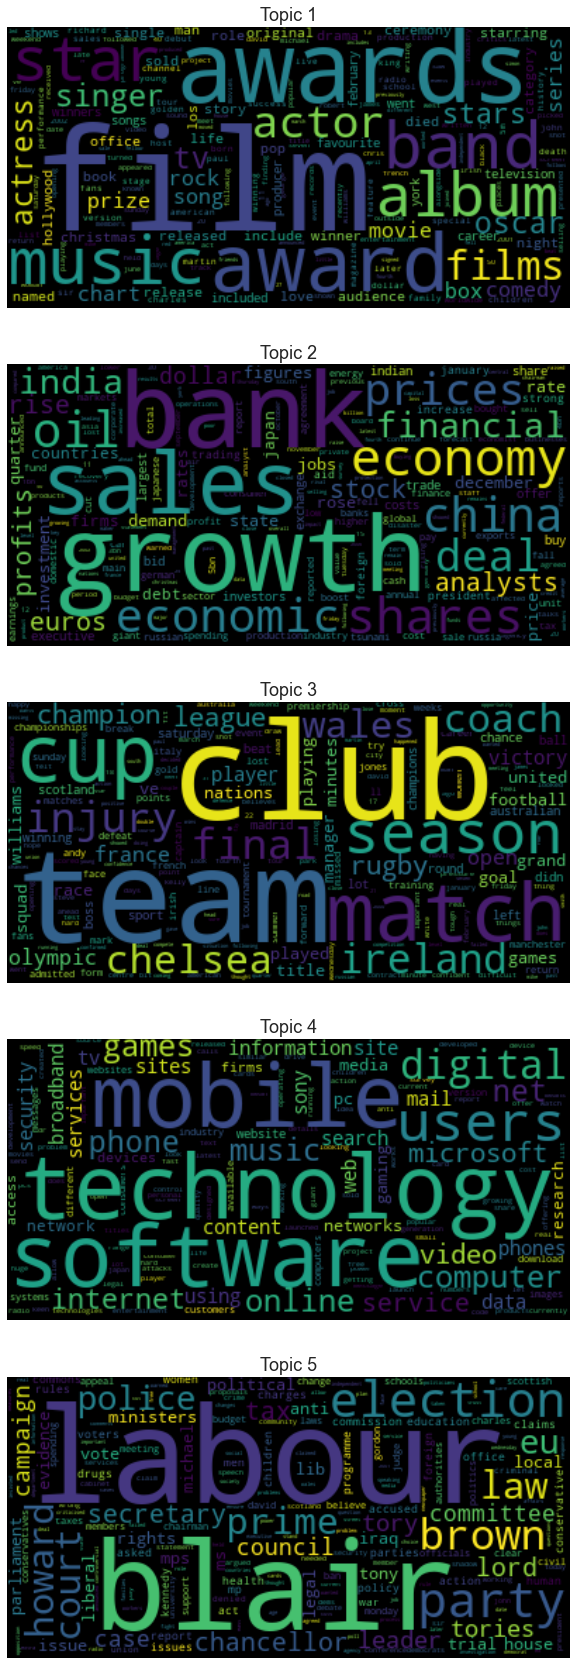

In [155]:
################################################################
#    Adapted from....
#    Title: Topic Modeling for Earnings Calls and Financial News
#    Author: Stefan Jansen
#    Date: 2020
#    Code version: Second Edition - Alpha
#    Availability: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/tree/master/15_topic_modeling
################################################################
topics_prob = lda.components_ / lda.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=pipeline_vectorizer.get_feature_names(),
                      columns=topic_labels)
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(15, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

## Visualize topic-word associations per document

You can gain insight into misclassifications by using a color scheme that shows which words in a document are associated with which LDA topic.

According to the BBC dataset, the document printed below belongs to the "Politics" class but was classified by LDA as "Tech." After looking it over, you might agree with me that LDA corrected a misclassification in the BBC corpus!

In [156]:
################################################################
#    Adapted from....
#    Title: Topic Modeling for Earnings Calls and Financial News
#    Author: Stefan Jansen
#    Date: 2020
#    Code version: Second Edition - Alpha
#    Availability: https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/tree/master/15_topic_modeling
################################################################
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'yellow', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'red', 'on_color': 'on_white'}
color_dict['Topic 4'] = {'color': 'yellow', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}
colored_text = []
for word in misclassified.iloc[3, 2].strip().split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)

print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print(f'\n{misclassified.iloc[3, 2].lstrip()}\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

UK firms are embracing internet trading opportunities as never before, e-commerce minister Mike O'Brien says.  A government-commissioned study ranked the UK third in its world index of use of information and communication technology (ICT). The report suggests 69% of UK firms are now using broadband and that 30% of micro businesses are trading online. Mr O'Brien said UK businesses were sprinting forward in ICT use, but that there were more challenges ahead. The report, carried out independently by consultants Booz Allen Hamilton and HI Europe, placed the UK third behind Sweden and Ireland for business use of ICT.  It showed British business brought greater maturity to their ICT use, by using broadband in increased numbers, bringing ICT into their business plans and using new technologies such as voice activated programmes and desktop video conferences. Mr O'Brien said: "The increase in the proportion of business connected by broadband shows that 